In [22]:
import os
import sys
import torch
import numpy as np
import SimpleITK as sitk

from PIL import Image

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

from pyradiomics_api import pyradiomics_glcm
from diffglcm import DiffGLCM

(32, 32)


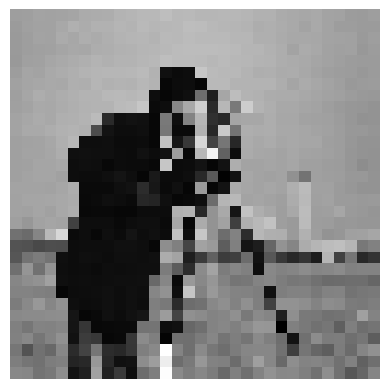

In [23]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import os
import torch
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm
from torch import cat
from einops import einsum
from einops import rearrange
from matplotlib import pyplot as plt
from radiomics import base, cMatrices, deprecated
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Cameraman.png and convert to numpy array with values in range 0-1
img = Image.open(r'../../Cameraman.png').convert('L')  # Convert to grayscale
x = np.array(img) / 255.0
x = x[::8, ::8]

# Display the image
plt.imshow(x, cmap='gray')
plt.axis('off')
print(x.shape)

In [24]:
# Initialize DiffGLCM
diffglcm = DiffGLCM(
    image_size=x.shape[0],  # Assuming square image
    low_bound=0,
    high_bound=1,
    Ng=64,
    alpha=1,
    differentiable=True
).to(device)

In [25]:
# Accuracy Test
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_tensor = torch.tensor(x, dtype=torch.float32, device=device)
image_tensor = image_tensor.unsqueeze(0).unsqueeze(0)
diffrad_glcm, diffrad_features = diffglcm(image_tensor, offset_r=1, offset_c=0)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
N=32
pytorch_gradients = np.zeros((24, N, N))

for i in tqdm(range(24)):
    image_tensor = torch.from_numpy(x).unsqueeze(0).unsqueeze(0).float().to(device)
    image_tensor.requires_grad = True
    
    diffrad_glcm, diffrad_features = diffglcm(image_tensor, offset_r=0, offset_c=1)

    feature = diffrad_features[0, i, 0]
    feature.backward()
    gradients = image_tensor.grad
    pytorch_gradients[i] = gradients[0, 0].detach().cpu().numpy()


100%|██████████| 24/24 [00:02<00:00,  9.60it/s]


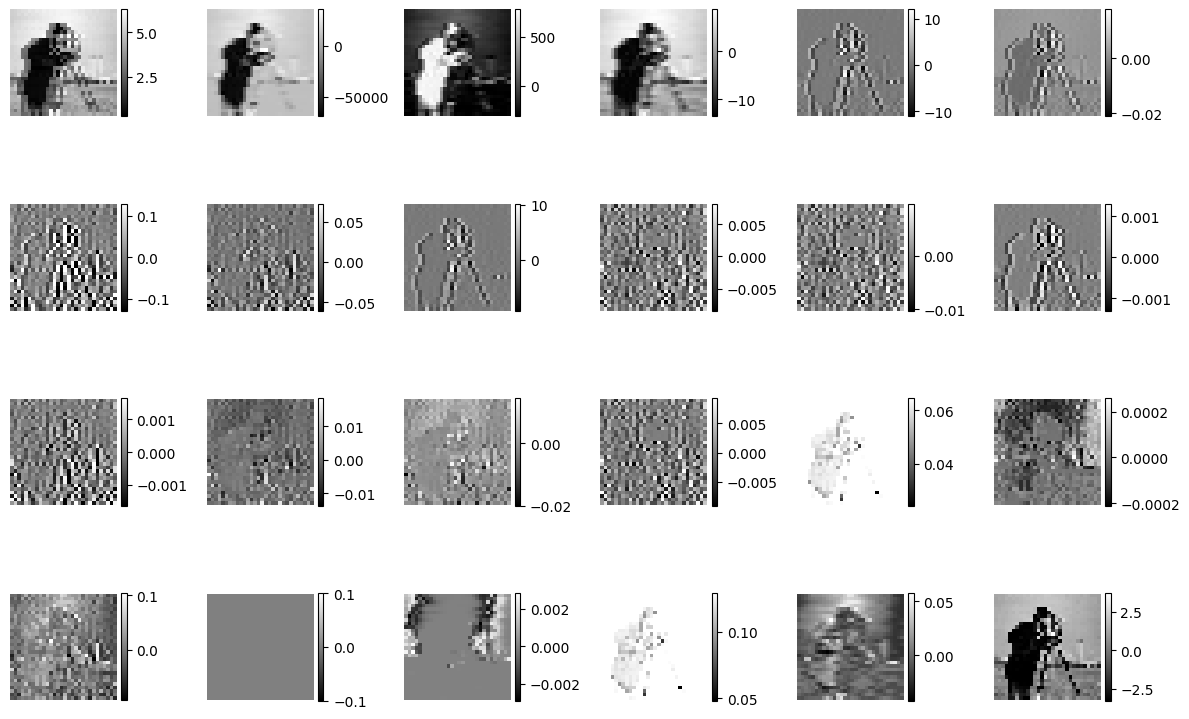

In [27]:
rol = 4
col = 6
fig, ax = plt.subplots(rol, col, figsize=(col * 2, rol * 2))
for i in range(rol):
    for j in range(col):
        im0 = ax[i, j].imshow(pytorch_gradients[i * col + j, 1:-1, 1:-1], cmap='gray')
        ax[i, j].axis('off')
        # Add colorbar for each subplot
        cbar = fig.colorbar(im0, ax=ax[i, j], fraction=0.046, pad=0.04)
        # Set label for colorbar
        # cbar.set_label('Gradient Magnitude')
plt.tight_layout()
plt.show()

In [33]:
from copy import deepcopy
from pyradiomics_api import pyradiomics_glcm
N = 32 # Square Patch
Ng = 64
binwidth = 1 / Ng

gradients_pyradiomics = np.zeros((24, N, N))
for i in tqdm(range(N)):
    for j in range(N):
        x_plus = deepcopy(x) 
        x_plus[i, j] += binwidth
        x_plus[x_plus > 1] = 1
        
        _, feature_plus = pyradiomics_glcm(x_plus, 0, 1, Ng, symmetricalGLCM=False, angle=(0,1))
        feature_plus = np.array([float(val[0]) for val in feature_plus.values()])
        
        x_minus = deepcopy(x)
        x_minus[i, j] -= binwidth
        x_minus[x_minus < 0] = 0
        
        _, feature_minus = pyradiomics_glcm(x_minus, 0, 1, Ng, symmetricalGLCM=False, angle=(0,1))
        feature_minus = np.array([float(val[0]) for val in feature_minus.values()])

        feature_delta = feature_plus - feature_minus

        gradients_pyradiomics[:, i, j] = feature_delta / (2*binwidth)

100%|██████████| 32/32 [00:40<00:00,  1.25s/it]


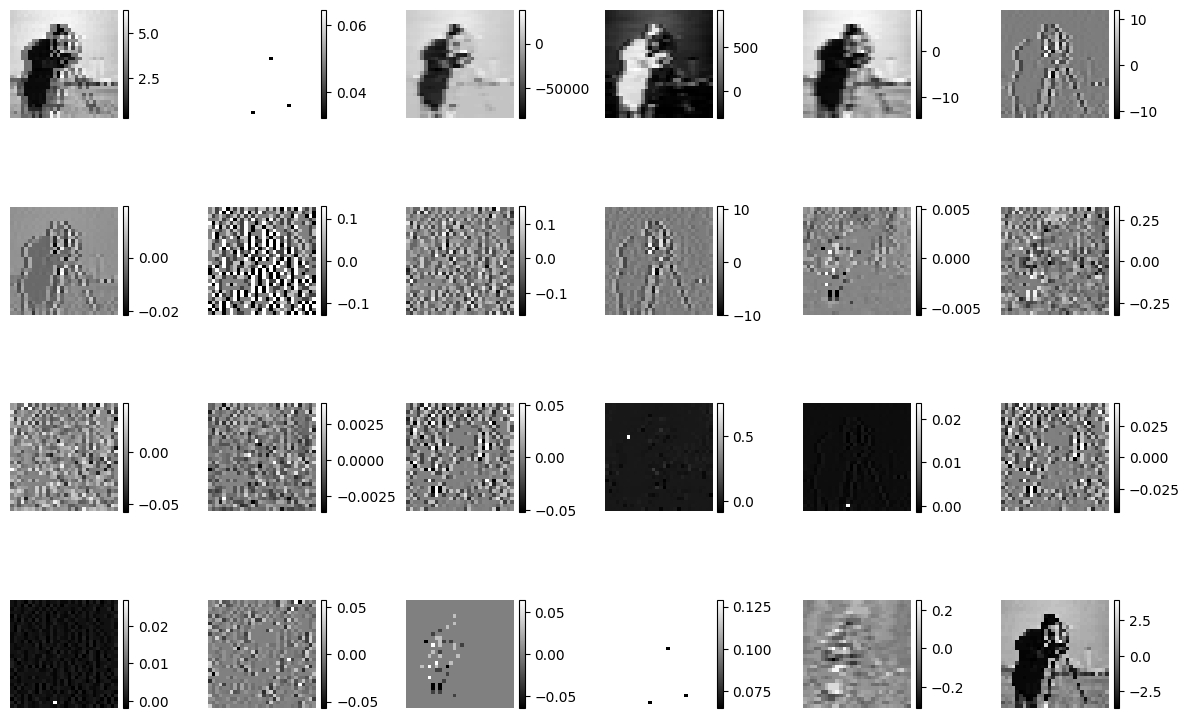

In [34]:
rol = 4
col = 6
fig, ax = plt.subplots(rol, col, figsize=(col * 2, rol * 2))
for i in range(rol):
    for j in range(col):
        im0 = ax[i, j].imshow(gradients_pyradiomics[i * col + j, 1:-1, 1:-1], cmap='gray')
        ax[i, j].axis('off')
        # Add colorbar for each subplot
        cbar = fig.colorbar(im0, ax=ax[i, j], fraction=0.046, pad=0.04)
        # Set label for colorbar
        # cbar.set_label('Gradient Magnitude')
plt.tight_layout()
plt.show()